# <span style="color:green">Análise de dados da base do Titanic</span>

## Base de dados - import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,
    preprocessing,
    tree,
)

url = ("https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls")
df = pd.read_excel(url)
orig_df = df
df.sample(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1220,3,0,"Spinner, Mr. Henry John",male,32.0,0,0,STON/OQ. 369943,8.0500,NaN,S,NaN,NaN,NaN
802,3,0,"Flynn, Mr. John",male,NaN,0,0,368323,6.9500,NaN,Q,NaN,NaN,NaN
637,3,0,"Aronsson, Mr. Ernst Axel Algot",male,24.0,0,0,349911,7.7750,NaN,S,NaN,NaN,"Sweden Joliet, IL"
275,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C,3,NaN,"Tuxedo Park, NY"
500,2,0,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S,NaN,NaN,"Rochester, NY"
200,1,0,"McCaffry, Mr. Thomas Francis",male,46.0,0,0,13050,75.2417,C6,C,NaN,292.0,"Vancouver, BC"
1051,3,0,"Nancarrow, Mr. William Henry",male,33.0,0,0,A./5. 3338,8.0500,NaN,S,NaN,NaN,NaN
1164,3,0,"Saad, Mr. Amin",male,NaN,0,0,2671,7.2292,NaN,C,NaN,NaN,NaN
1079,3,1,"Ohman, Miss. Velin",female,22.0,0,0,347085,7.7750,NaN,S,C,NaN,NaN
316,1,0,"Williams, Mr. Charles Duane",male,51.0,0,1,PC 17597,61.3792,NaN,C,NaN,NaN,"Geneva, Switzerland / Radnor, PA"


## Adicionando colunas com informações da cabine

In [4]:
orig_df = df
agg = (
     df.groupby("cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index()
)
agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]
agg_df = df.merge(agg, on="cabin")
agg_df.sample(5)

C:\Users\barba\AppData\Local\Temp\ipykernel_5812\2851318775.py:3: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("cabin")


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,parch_mean,parch_sum,fare_min,fare_max,fare_mean,fare_sum,body_min,body_max,body_mean,body_sum
175,1,1,"Marvin, Mrs. Daniel Warner (Mary Graham Carmic...",female,18.0,1,0,113773,53.1000,D30,...,0.0,0,53.1000,53.1000,53.1000,106.2000,NaN,NaN,NaN,0.0
293,3,0,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,...,1.2,6,10.4625,16.7000,14.2050,71.0250,NaN,NaN,NaN,0.0
5,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.2000,135.0,135.0,135.0,135.0
220,1,1,"Snyder, Mr. John Pillsbury",male,24.0,1,0,21228,82.2667,B45,...,0.0,0,82.2667,82.2667,82.2667,164.5334,NaN,NaN,NaN,0.0
132,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,...,0.0,0,76.7292,76.7292,76.7292,153.4584,NaN,NaN,NaN,0.0


## Limpeza de colunas e divisão entre dados de treino, teste e modelo inicial

In [5]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [6]:
X.sample(5)

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
287,-1.551881,2.526096,-0.498616,0.0,-0.025527,1,0,1
993,0.825248,-0.166585,-0.498616,0.0,-0.491145,0,1,0
1182,0.825248,-0.595449,-0.498616,0.0,-0.492802,0,0,1
430,-0.363317,-1.766028,-0.498616,1.0,-0.012663,0,0,1
1019,0.825248,-0.361333,-0.498616,0.0,-0.488146,1,0,1


## Análise de correlação das colunas, identificando coeficiente maior que 0.95

In [9]:
limit = 0.95
corr = agg_df.corr()
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_no_diag = corr.where(mask)
coll = [ c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
coll

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

### Heatmap das dependências

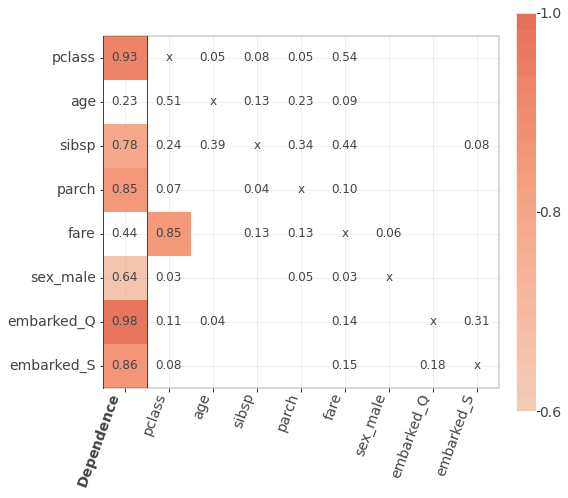

In [10]:
import rfpimp
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()
fig.savefig(
    "images/mlpr_0801.png",
    dpi=300,
    bbox_inches="tight",
)

observa-se que, as demais categorias podem ser previstas à partir da "fare" e "pclass"

## Teste de hipotese: "fare" é o suficiente para criar um modelo preditivo.

### Removendo as colunas e implantando o modelo Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
cols_to_remove = [
    "pclass",
    "sibsp",
    "parch",
    "embarked_Q",
]

rf3 = RandomForestClassifier(random_state=42)
rf3.fit(
    X_train[
        [c for c in X_train.columns if c not in cols_to_remove]
    ],
    y_train,
)
rf3.score(
    X_test[
        [c for c in X_train.columns if c not in cols_to_remove]
    ],
    y_test,
)


0.7582697201017812

In [13]:
rf4 = RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

0.7938931297709924

Observa-se que removendo as demais colunas, o modelo se manteve com um score acima de 0.7

## Regressão Lasso, iterando por diversos valores de alpha e monitorando os coeficientes dos atributos

C:\ProgramData\Anaconda3\envs\Machine-Learning-guia-referencia\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


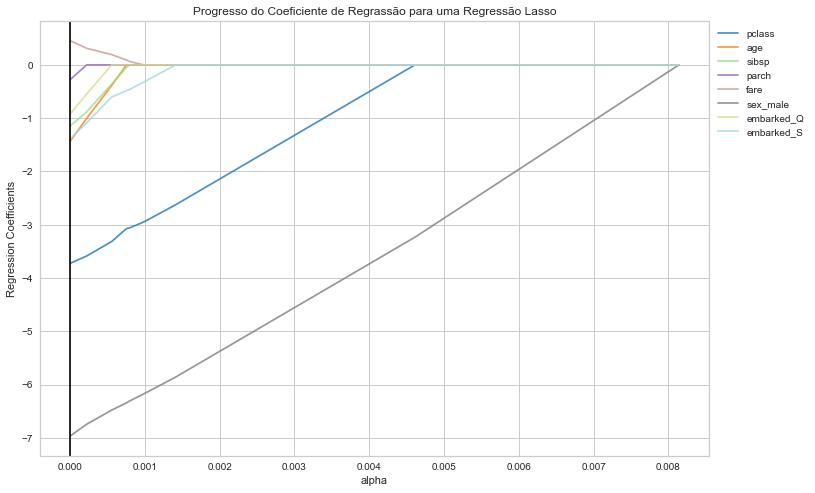

In [18]:
from sklearn import linear_model
model = linear_model.LassoLarsCV( cv=10, max_n_alphas=10 ).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12, 8))
cm = iter( plt.get_cmap("tab20")(np.linspace(0, 1, X.shape[1])))

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i],
    )

ax.axvline(
    model.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)
plt.ylabel("Regression Coefficients")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Progresso do Coeficiente de Regrassão para uma Regressão Lasso"
)
fig.savefig(
    "images/mlpr_0802.png",
    dpi=300,
    bbox_inches="tight",
)

## Eliminação Recursiva de atributos para adequação do modelo

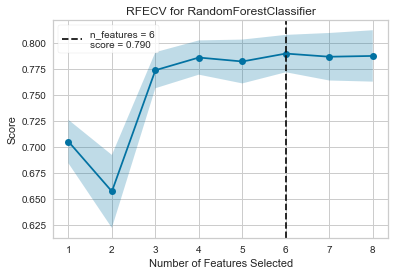

In [15]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5,
)
rfe.fit(X, y)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
rfe.poof()
fig.savefig("images/mlpr_0803.png", dpi=300)

In [16]:
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model, 4)
rfe.fit(X, y)
X.columns[rfe.support_]

TypeError: __init__() takes 2 positional arguments but 3 were given

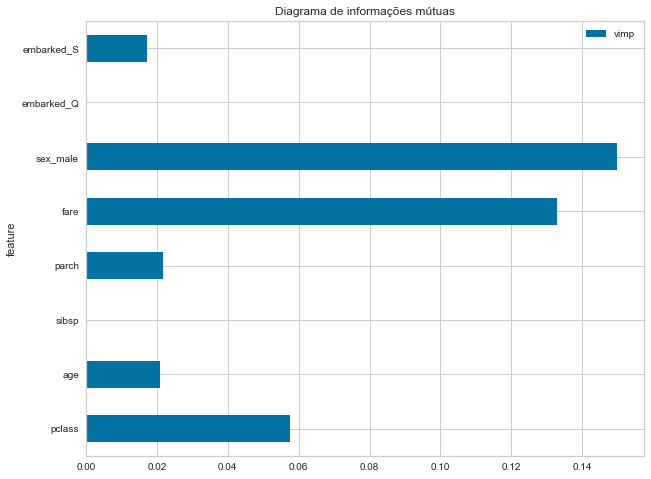

In [19]:
from sklearn import feature_selection
mic = feature_selection.mutual_info_classif(
    X, y
)
fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {"feature": X.columns, "vimp": mic}
    )
    .set_index("feature")
    .plot.barh(ax=ax)
)
plt.title(
    "Diagrama de informações mútuas"
)
fig.savefig("images/mlpr_0804.png")